# NFL Big Data Bowl 2026 - Model Training

This notebook contains data preprocessing, feature engineering, and model training without EDA visualizations.

### Requirements
- Create environment using requirements.txt
- Folder structure:
  - train/ - folder with training CSV files
  - cache/ and results/ folders will be created automatically


In [1]:
import os
import re
import glob
import json
import joblib

import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.neighbors import KDTree
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Data Loading and Preparation

In [4]:
files_input = sorted(glob.glob("train/input_2023_w*.csv"))
files_output = sorted(glob.glob("train/output_2023_w*.csv"))

INPUT_DFS = []
OUTPUT_DFS = []

for f_in, f_out in zip(files_input, files_output):
    df_in = pd.read_csv(f_in)
    df_out = pd.read_csv(f_out)

    week_match = re.search(r"w(\d+)", f_out)
    week = int(week_match.group(1)) if week_match else None

    df_in["week"] = week
    df_out["week"] = week

    INPUT_DFS.append(df_in)
    OUTPUT_DFS.append(df_out)

    print(f"{f_in}: {df_in.shape}, {f_out}: {df_out.shape}, week: {week}")

train\input_2023_w01.csv: (285714, 24), train\output_2023_w01.csv: (32088, 7), week: 1
train\input_2023_w02.csv: (288586, 24), train\output_2023_w02.csv: (32180, 7), week: 2
train\input_2023_w03.csv: (297757, 24), train\output_2023_w03.csv: (36080, 7), week: 3
train\input_2023_w04.csv: (272475, 24), train\output_2023_w04.csv: (30147, 7), week: 4
train\input_2023_w05.csv: (254779, 24), train\output_2023_w05.csv: (29319, 7), week: 5
train\input_2023_w06.csv: (270676, 24), train\output_2023_w06.csv: (31162, 7), week: 6
train\input_2023_w07.csv: (233597, 24), train\output_2023_w07.csv: (27443, 7), week: 7
train\input_2023_w08.csv: (281011, 24), train\output_2023_w08.csv: (33017, 7), week: 8
train\input_2023_w09.csv: (252796, 24), train\output_2023_w09.csv: (28291, 7), week: 9
train\input_2023_w10.csv: (260372, 24), train\output_2023_w10.csv: (29008, 7), week: 10
train\input_2023_w11.csv: (243413, 24), train\output_2023_w11.csv: (27623, 7), week: 11
train\input_2023_w12.csv: (294940, 24), t

In [5]:
eda_df = pd.concat(INPUT_DFS, ignore_index=True)
eda_df.shape

(4880579, 24)

## Direction Manipulations (Normalization)

To ensure data consistency (so that all attacking plays move in the same direction)
we mirror all plays moving to the left, so that:
1. Every attacking play moves towards the right end zone.
2. Coordinate and angular values ​​become comparable for all plays.

In [6]:
X_LIMIT = 120
Y_LIMIT = 53.3

In [7]:
right_eda = eda_df[eda_df["play_direction"] == "right"].copy()
left_eda = eda_df[eda_df["play_direction"] == "left"].copy()

right_eda["was_left"] = 0
left_eda["was_left"]  = 1

right_eda.shape, left_eda.shape

((2459074, 25), (2421505, 25))

In [8]:
left_eda["x"] = X_LIMIT - left_eda["x"]
left_eda["y"] = Y_LIMIT - left_eda["y"]

left_eda["ball_land_x"] = X_LIMIT - left_eda["ball_land_x"]
left_eda["ball_land_y"] = Y_LIMIT - left_eda["ball_land_y"]

left_eda["dir"] = (left_eda["dir"] + 180) % 360
left_eda["o"] = (left_eda["o"] + 180) % 360

left_eda["play_direction"] = "right"

In [9]:
eda_df_normalized = pd.concat([right_eda, left_eda], ignore_index=True)

## Data Cleaning and Feature Engineering

In [10]:
df = eda_df_normalized.copy()

In [11]:
df = df[df["x"].between(0, X_LIMIT)]
df = df[df["y"].between(0, Y_LIMIT)]

df = df[df["ball_land_x"].between(0, X_LIMIT)]
df = df[df["ball_land_y"].between(0, Y_LIMIT)]

### Kinematic features

In [12]:
# Heading to radians
df["dir_rad"] = np.deg2rad(df["dir"])

# Velocity components
df["vx"] = df["s"] * np.cos(df["dir_rad"])
df["vy"] = df["s"] * np.sin(df["dir_rad"])

# Acceleration components
df["ax"] = df["a"] * np.cos(df["dir_rad"])
df["ay"] = df["a"] * np.sin(df["dir_rad"])

# Angle from player to ball landing point and distance
dx_ball = (df["ball_land_x"] - df["x"])
dy_ball = (df["ball_land_y"] - df["y"])
df["dist_to_ball"] = np.sqrt(dx_ball*dx_ball + dy_ball*dy_ball)
df["angle_to_ball"] = np.arctan2(dy_ball, dx_ball)

# Velocity component directed toward the ball
df["v_toward_ball"] = df["vx"] * np.cos(df["angle_to_ball"]) + df["vy"] * np.sin(df["angle_to_ball"])

### Spatial features

In [13]:
# Distance to sidelines/endzone in the normalized frame
df["dist_to_left_sideline"]  = df["y"]  # y grows upward
df["dist_to_right_sideline"] = X_LIMIT - df["y"]  # distance to top boundary
df["dist_to_endzone"] = Y_LIMIT - df["x"]  # moving toward right endzone

# Normalized frame index within predicted horizon (0..1)
den = pd.to_numeric(df["num_frames_output"], errors="coerce").replace(0, np.nan)
df["frame_norm"] = df["frame_id"] / den

### Player features

In [14]:
# Static player features
def _h_m(h):
    try:
        feet, inch = str(h).split("-")
        return (int(feet)*12 + int(inch)) * 0.0254
    except:
        return np.nan
df["height_m"] = df["player_height"].map(_h_m) # in meters

birth = pd.to_datetime(df["player_birth_date"], errors="coerce")
df["age_years"] = (pd.Timestamp("2025-01-01") - birth).dt.days / 365.25

### Team context aggregates

In [15]:
group_keys = ["game_id","play_id","frame_id","player_side"]

In [16]:
agg_frame_side = (
    df.groupby(group_keys)
      .agg(
          team_mean_s=("s","mean"),
          team_std_s=("s","std"),
          team_mean_a=("a","mean"),
          team_mean_dist_ball=("dist_to_ball","mean"),
          team_count=("nfl_id","nunique")
      )
      .reset_index()
)

df = df.merge(agg_frame_side, on=group_keys, how="left")

### Nearest defender distance

In [17]:
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [18]:
weeks_sorted = sorted(df["week"].dropna().unique().tolist())

nearest_parts = [] 

for wk in weeks_sorted:
    cache_path = os.path.join(CACHE_DIR, f"nearest_defender_w{int(wk):02d}.parquet")
    print(f"\n[Week {wk:02d}]")

    # If cache exists, just load and move on
    if os.path.exists(cache_path):
        print(f"Loading from cache: {cache_path}")
        nearest_w = pd.read_parquet(cache_path)
        nearest_parts.append(nearest_w)
        continue

    # Slice week data
    df_w = df[df["week"] == wk]

    # Split targets and defenders
    targets_w  = df_w[df_w["player_to_predict"] == True][
        ["game_id","play_id","frame_id","nfl_id","x","y"]
    ].copy()
    defenders_w = df_w[df_w["player_side"] == "Defense"][
        ["game_id","play_id","frame_id","x","y"]
    ].copy()

    # Early exit if no targets or defenders
    if targets_w.empty or defenders_w.empty:
        print("No targets or defenders in this week; writing empty cache.")
        nearest_w = targets_w[["game_id","play_id","frame_id","nfl_id"]].copy()
        nearest_w["nearest_defender_dist"] = np.nan
        nearest_w.to_parquet(cache_path, index=False)
        nearest_parts.append(nearest_w)
        continue

    # Group by per-frame key to avoid Cartesian explosion
    key_cols = ["game_id","play_id","frame_id"]
    defenders_grp = defenders_w.groupby(key_cols)
    targets_grp   = targets_w.groupby(key_cols)

    # Iterate only over frames that actually have targets
    nearest_chunk_list = []

    # To speed up, prebuild a small dict of defenders per frame (coordinates arrays)
    # and (if KDTree available) build KDTree once per frame.
    # This is memory-savvy because we keep only current frame arrays in scope.
    for key, tg in targets_grp:
        # key is a tuple (gid, pid, fid)
        # defenders in the same frame:
        try:
            def_frame = defenders_grp.get_group(key)
        except KeyError:
            # no defenders in this frame
            tmp = tg[["game_id","play_id","frame_id","nfl_id"]].copy()
            tmp["nearest_defender_dist"] = np.nan
            nearest_chunk_list.append(tmp)
            continue

        # If defenders exist, compute nearest distance for tg -> def_frame
        P = tg[["x","y"]].to_numpy()
        Q = def_frame[["x","y"]].to_numpy()

        if (len(Q) == 0) or (len(P) == 0):
            tmp = tg[["game_id","play_id","frame_id","nfl_id"]].copy()
            tmp["nearest_defender_dist"] = np.nan
            nearest_chunk_list.append(tmp)
            continue

        # Fast nearest neighbor query
        tree = KDTree(Q, leaf_size=32)
        # Query for k=1 nearest defender
        dist, _ = tree.query(P, k=1, return_distance=True)
        dmin = dist.reshape(-1)

        tmp = tg[["game_id","play_id","frame_id","nfl_id"]].copy()
        tmp["nearest_defender_dist"] = dmin
        nearest_chunk_list.append(tmp)

    # Concatenate all frames for this week
    nearest_w = pd.concat(nearest_chunk_list, ignore_index=True)

    # Save to cache
    nearest_w.to_parquet(cache_path, index=False)
    print(f"  -> Saved cache: {cache_path} | rows: {len(nearest_w)}")

    nearest_parts.append(nearest_w)


[Week 01]
Loading from cache: cache\nearest_defender_w01.parquet

[Week 02]
Loading from cache: cache\nearest_defender_w02.parquet

[Week 03]
Loading from cache: cache\nearest_defender_w03.parquet

[Week 04]
Loading from cache: cache\nearest_defender_w04.parquet

[Week 05]
Loading from cache: cache\nearest_defender_w05.parquet

[Week 06]
Loading from cache: cache\nearest_defender_w06.parquet

[Week 07]
Loading from cache: cache\nearest_defender_w07.parquet

[Week 08]
Loading from cache: cache\nearest_defender_w08.parquet

[Week 09]
Loading from cache: cache\nearest_defender_w09.parquet

[Week 10]
Loading from cache: cache\nearest_defender_w10.parquet

[Week 11]
Loading from cache: cache\nearest_defender_w11.parquet

[Week 12]
Loading from cache: cache\nearest_defender_w12.parquet

[Week 13]
Loading from cache: cache\nearest_defender_w13.parquet

[Week 14]
Loading from cache: cache\nearest_defender_w14.parquet

[Week 15]
Loading from cache: cache\nearest_defender_w15.parquet

[Week 16]

In [19]:
nearest_all = pd.concat(nearest_parts, ignore_index=True)
print("All weeks nearest-defender rows:", len(nearest_all))

df = df.merge(
    nearest_all,
    on=["game_id","play_id","frame_id","nfl_id"],
    how="left"
)

All weeks nearest-defender rows: 1281024


In [20]:
targets = df[df["player_to_predict"] == True].copy()

### Mean defender distance to ball

In [21]:
def_df = df[df["player_side"]=="Defense"][["game_id","play_id","frame_id","x","y","ball_land_x","ball_land_y"]].copy()
def_df["dist_ball_def"] = np.sqrt((def_df["ball_land_x"]-def_df["x"])**2 + (def_df["ball_land_y"]-def_df["y"])**2)

def_pressure = (
    def_df.groupby(["game_id","play_id","frame_id"])
          .agg(def_mean_dist_ball=("dist_ball_def","mean"))
          .reset_index()
)

targets = targets.merge(def_pressure, on=["game_id","play_id","frame_id"], how="left")

### Prepare target dataframe

In [22]:
df_ready = targets.copy()

## Advanced feature engineering

In [23]:
eps = 1e-3

# Filter out stationary players
df_ready_filtered = df_ready[df_ready["s"] > 0.3].copy()

### Time-to-ball, relative velocity

In [24]:
df_ready_filtered["time_to_ball"]  = df_ready_filtered["dist_to_ball"] / (df_ready_filtered["s"] + eps)
df_ready_filtered["v_rel_to_ball"] = df_ready_filtered["v_toward_ball"] / (df_ready_filtered["s"] + eps)

ttb_clip = df_ready_filtered["time_to_ball"].quantile(0.99) # clip extreme tail (99th percentile)
df_ready_filtered["time_to_ball"] = df_ready_filtered["time_to_ball"].clip(0, ttb_clip)
df_ready_filtered["log_time_to_ball"] = np.log1p(df_ready_filtered["time_to_ball"])

df_ready_filtered["v_rel_to_ball"] = df_ready_filtered["v_rel_to_ball"].clip(-1.0, 1.0)

### Heading alignment (cosine of angle difference)

In [25]:
# cos() = 1 means "fully toward the ball", -1 means "fully away"
df_ready_filtered["angle_diff"] = df_ready_filtered["dir_rad"] - df_ready_filtered["angle_to_ball"]

# wrap to [-pi, pi] for numerical stability
df_ready_filtered["angle_diff"] = (df_ready_filtered["angle_diff"] + np.pi) % (2*np.pi) - np.pi
df_ready_filtered["cos_to_ball"] = np.cos(df_ready_filtered["angle_diff"])
df_ready_filtered["sin_to_ball"] = np.sin(df_ready_filtered["angle_diff"])

### Pressure index (the smaller the distance, the bigger the pressure)

In [26]:
df_ready_filtered["pressure_index"] = 1.0 / (df_ready_filtered["nearest_defender_dist"].fillna(10.0) + 0.5)

df_ready_filtered["pressure_index"] = df_ready_filtered["pressure_index"].clip(0, 5)
df_ready_filtered["pressure_index_norm"] = df_ready_filtered["pressure_index"] / df_ready_filtered["pressure_index"].max()

### Normalized coordinates [0, 1]

In [27]:
df_ready_filtered["x_norm"] = df_ready_filtered["x"] / X_LIMIT
df_ready_filtered["y_norm"] = df_ready_filtered["y"] / Y_LIMIT

### Forward progress proxies

In [28]:
df_ready_filtered["is_moving_forward"] = (df_ready_filtered["vx"] > 0).astype(np.int8)
df_ready_filtered["forward_speed"] = df_ready_filtered["vx"].clip(lower=0.0)  # only downfield component

### Additional cleaning

In [29]:
df_ready_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)

# Moderate outlier removal (prevents scale distortion due to incorrect sensor readings)
df_ready_filtered = df_ready_filtered[(df_ready_filtered["s"] <= 12) & (df_ready_filtered["a"] <= 15)]
df_ready_filtered.dropna(inplace=True)

## Save processed features

In [30]:
feature_cols = [
    # identifiers
    "game_id", "play_id", "nfl_id", "frame_id", "week",

    # positions / motion
    "x", "y", "s", "a", "dir", "o", "dir_rad", "vx", "vy", "ax", "ay",

    # ball geometry
    "dist_to_ball", "angle_to_ball", "v_toward_ball",

    # advanced features
    "time_to_ball", "log_time_to_ball", "v_rel_to_ball", "angle_diff", "cos_to_ball", "sin_to_ball",
    "pressure_index", "pressure_index_norm", "x_norm", "y_norm", "is_moving_forward", "forward_speed",

    # team context
    "team_mean_s", "team_std_s", "team_mean_a", "team_mean_dist_ball", "team_count",

    # extra spatial
    "dist_to_left_sideline", "dist_to_right_sideline", "dist_to_endzone", "frame_norm",

    # optional player data
    "height_m", "age_years", "player_position", "player_role", "player_side"
]

df_ready_filtered[feature_cols].to_parquet(f"{RESULTS_DIR}/targets_features_advanced_ALL.parquet", index=False, engine='fastparquet')

# Model Training

## Data preparation

In [31]:
outputs = pd.concat(OUTPUT_DFS, ignore_index=True)

outputs.shape

(562936, 7)

In [32]:
# take the last input frame per player (t0 before throw)
t0 = (
    df_ready_filtered
    .sort_values("frame_id")
    .groupby(["game_id","play_id","nfl_id", "week"], as_index=False)
    .tail(1)
    .copy()
)

In [33]:
t0 = t0.rename(columns={
    "frame_id": "frame_id_in",
    "x": "x0",
    "y": "y0",
})

In [34]:
outputs_renamed = outputs.rename(columns={
    "frame_id": "frame_id_out",
    "x": "x_out", 
    "y": "y_out",
})

In [35]:
data = t0.merge(
    outputs_renamed,
    on=["game_id", "play_id", "nfl_id", "week"],
    how="inner",
)


In [36]:
print("t0 shape:", t0.shape, "outputs shape:", outputs_renamed.shape, "merged shape:", data.shape)

t0 shape: (45287, 58) outputs shape: (562936, 7) merged shape: (548217, 61)


## Alternative Model: Temporal Lags with Single t+1 Prediction


### Create temporal lag features for x positions


In [82]:
# Get the last 4 input frames for each player (t-3, t-2, t-1, t0)
# We need to go back to df_ready_filtered which has all input frames

# Sort by frame_id and get last 4 frames per player
df_sorted = df_ready_filtered.sort_values(["game_id", "play_id", "nfl_id", "week", "frame_id"])

# Group by player and get last 4 frames
lag_frames = (
    df_sorted
    .groupby(["game_id", "play_id", "nfl_id", "week"])
    .tail(4)
    .copy()
)

# Create a sequence number within each player (from oldest to newest)
lag_frames["seq"] = (
    lag_frames
    .groupby(["game_id", "play_id", "nfl_id", "week"])
    .cumcount()
)

# Filter only players who have exactly 4 frames
player_counts = lag_frames.groupby(["game_id", "play_id", "nfl_id", "week"]).size()
valid_players = player_counts[player_counts == 4].index

lag_frames_filtered = lag_frames[
    lag_frames.set_index(["game_id", "play_id", "nfl_id", "week"]).index.isin(valid_players)
].copy()

print(f"Players with exactly 4 lag frames: {len(valid_players)}")

# Pivot to create lag columns
lag_pivot = lag_frames_filtered.pivot_table(
    index=["game_id", "play_id", "nfl_id", "week"],
    columns="seq",
    values="x",
    aggfunc="first"
).reset_index()

# Rename columns to t_lag_-3, t_lag_-2, t_lag_-1, t_lag_0
lag_pivot.columns.name = None
lag_pivot = lag_pivot.rename(columns={
    0: "t_lag_-3",
    1: "t_lag_-2", 
    2: "t_lag_-1",
    3: "t_lag_0"
})

print(f"Lag pivot shape: {lag_pivot.shape}")
lag_pivot.head()


Players with exactly 4 lag frames: 45250
Lag pivot shape: (45250, 8)


,game_id,play_id,nfl_id,week,t_lag_-3,t_lag_-2,t_lag_-1,t_lag_0
0,2023090700,194,41325,1,29.41000,29.93000,30.47000,31.02000
1,2023090700,194,44888,1,34.74000,34.71000,34.68000,34.65000
2,2023090700,194,53953,1,41.35000,41.92000,42.44000,42.90000
3,2023090700,194,54653,1,28.14000,28.44000,28.79000,29.21000
4,2023090700,194,55910,1,41.35000,41.76000,42.13000,42.45000


### Create input matrix (one row per player)


In [83]:
# Merge t0 features with lag features
input_matrix_x = t0.merge(
    lag_pivot,
    on=["game_id", "play_id", "nfl_id", "week"],
    how="inner"
)

# Remove x_norm and y_norm columns
cols_to_remove = ["x_norm", "y_norm"]
cols_to_keep = [c for c in input_matrix_x.columns if c not in cols_to_remove]
input_matrix_x = input_matrix_x[cols_to_keep]

print(f"Input matrix shape: {input_matrix_x.shape}")
print(f"Sample of temporal lag columns:")
print(input_matrix_x[["game_id", "play_id", "nfl_id", "t_lag_-3", "t_lag_-2", "t_lag_-1", "t_lag_0"]].head())


Input matrix shape: (45250, 60)
Sample of temporal lag columns:
      game_id  play_id  nfl_id  t_lag_-3  t_lag_-2  t_lag_-1  t_lag_0
0  2023112604     1588   55888  88.63000  88.66000  88.69000 88.72000
1  2023112604     1355   55888  26.62000  26.65000  26.68000 26.72000
2  2023092410     2619   53565  61.03000  60.94000  60.82000 60.71000
3  2023092410     2619   52425  50.91000  50.87000  50.81000 50.74000
4  2023111906      587   43327  97.00000  96.89000  96.76000 96.59000


### Create t+1 output vector


In [84]:
# Get only the first output frame (t+1) for each player
# Sort by frame_id_out and take the first one per player
outputs_t1 = (
    outputs_renamed
    .sort_values(["game_id", "play_id", "nfl_id", "week", "frame_id_out"])
    .groupby(["game_id", "play_id", "nfl_id", "week"])
    .first()
    .reset_index()
)

print(f"Output t+1 shape: {outputs_t1.shape}")

# Merge with input matrix
data_temporal = input_matrix_x.merge(
    outputs_t1,
    on=["game_id", "play_id", "nfl_id", "week"],
    how="inner"
)

print(f"Merged temporal data shape: {data_temporal.shape}")

# Normalize the output for left plays
mask = data_temporal["was_left"] == 1
data_temporal.loc[mask, "x_out"] = X_LIMIT - data_temporal.loc[mask, "x_out"]
data_temporal.loc[mask, "y_out"] = Y_LIMIT - data_temporal.loc[mask, "y_out"]

# Calculate t+1 displacement relative to t0
data_temporal["target_dx_t1"] = data_temporal["x_out"] - data_temporal["x0"]
data_temporal["target_dy_t1"] = data_temporal["y_out"] - data_temporal["y0"]

print(f"Target displacement statistics:")
print(data_temporal[["target_dx_t1", "target_dy_t1"]].describe())


Output t+1 shape: (46045, 7)
Merged temporal data shape: (45250, 63)
Target displacement statistics:
       target_dx_t1  target_dy_t1
count   45250.00000   45250.00000
mean        0.23524      -0.00934
std         0.24781       0.36666
min        -0.63000      -1.01000
25%         0.06000      -0.29000
50%         0.22000      -0.01000
75%         0.39000       0.26000
max         1.04000       0.97000


### Prepare features for temporal lag model


In [85]:
## Sequential Models 1-10: Automated Training Pipeline

print("="*70)
print("PREPARING DATA FOR SEQUENTIAL MODELS (t+1 through t+10)")
print("="*70)


PREPARING DATA FOR SEQUENTIAL MODELS (t+1 through t+10)


### Prepare all output frames (t+1 through t+10)


In [86]:
# Create datasets for each time step (t+1 through t+10)
# Store all displacements for X and Y in dictionaries

MAX_HORIZON = 10
all_displacements = {}  # Will store dataframes with all t+1 through t+10 displacements

print(f"\nExtracting output frames t+1 through t+{MAX_HORIZON}...")

for t in range(1, MAX_HORIZON + 1):
    outputs_t = (
        outputs_renamed
        .sort_values(["game_id", "play_id", "nfl_id", "week", "frame_id_out"])
        .groupby(["game_id", "play_id", "nfl_id", "week"])
        .nth(t - 1)  # 0-indexed, so t-1 gives us the t-th frame
        .reset_index()
    )
    
    # Merge with input_matrix
    data_t = input_matrix_x.merge(
        outputs_t,
        on=["game_id", "play_id", "nfl_id", "week"],
        how="inner"
    )
    
    # Normalize for left plays
    mask = data_t["was_left"] == 1
    data_t.loc[mask, "x_out"] = X_LIMIT - data_t.loc[mask, "x_out"]
    data_t.loc[mask, "y_out"] = Y_LIMIT - data_t.loc[mask, "y_out"]
    
    # Calculate displacements
    data_t[f"target_dx_t{t}"] = data_t["x_out"] - data_t["x0"]
    data_t[f"target_dy_t{t}"] = data_t["y_out"] - data_t["y0"]
    
    all_displacements[t] = data_t[["game_id", "play_id", "nfl_id", "week", 
                                     f"target_dx_t{t}", f"target_dy_t{t}"]].copy()
    
    print(f"  t+{t}: {len(all_displacements[t])} players")

print(f"\nCombining all displacements into master dataset...")



Extracting output frames t+1 through t+10...
  t+1: 45250 players
  t+2: 45250 players
  t+3: 45250 players
  t+4: 45250 players
  t+5: 45250 players
  t+6: 44996 players
  t+7: 43248 players
  t+8: 38657 players
  t+9: 32900 players
  t+10: 27472 players

Combining all displacements into master dataset...


### Build master dataset with all time steps


In [87]:
# Start with base features (no temporal displacements yet)
master_data = input_matrix_x.copy()

# Merge all displacement targets sequentially
for t in range(1, MAX_HORIZON + 1):
    master_data = master_data.merge(
        all_displacements[t],
        on=["game_id", "play_id", "nfl_id", "week"],
        how="left"  # Left join to keep all players
    )

print(f"Master dataset shape: {master_data.shape}")
print(f"\nColumns with displacement targets:")
target_cols = [c for c in master_data.columns if 'target_d' in c]
print(target_cols)

# Count how many output frames each player has
master_data['num_output_frames'] = master_data[[f"target_dx_t{t}" for t in range(1, MAX_HORIZON + 1)]].notna().sum(axis=1)
print(f"\nDistribution of players by number of output frames:")
print(master_data['num_output_frames'].value_counts().sort_index())


Master dataset shape: (45250, 80)

Columns with displacement targets:
['target_dx_t1', 'target_dy_t1', 'target_dx_t2', 'target_dy_t2', 'target_dx_t3', 'target_dy_t3', 'target_dx_t4', 'target_dy_t4', 'target_dx_t5', 'target_dy_t5', 'target_dx_t6', 'target_dy_t6', 'target_dx_t7', 'target_dy_t7', 'target_dx_t8', 'target_dy_t8', 'target_dx_t9', 'target_dy_t9', 'target_dx_t10', 'target_dy_t10']

Distribution of players by number of output frames:
num_output_frames
5       254
6      1748
7      4591
8      5757
9      5428
10    27472
Name: count, dtype: int64


### Train Sequential Models for X Displacement (Models 1-10)


In [88]:
import matplotlib.pyplot as plt

# LightGBM parameters
lgb_params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "n_estimators": 2000,
    "random_state": 42,
    "verbose": -1,
}

# Base feature columns (excluding targets, identifiers, and non-numeric columns)
exclude_cols = [
    # Identifiers
    "game_id", "play_id", "nfl_id", "week",
    # String/categorical columns that can't be converted to float
    "player_name", "player_position", "player_role", "player_side", "play_direction",
    "player_height", "player_birth_date",
    # Output columns
    "num_output_frames"
] + [f"target_dx_t{t}" for t in range(1, MAX_HORIZON + 1)] + [f"target_dy_t{t}" for t in range(1, MAX_HORIZON + 1)]

base_features = [c for c in master_data.columns if c not in exclude_cols]

# Additional safety check: ensure all base features are numeric
numeric_base_features = []
for col in base_features:
    if master_data[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int8', 'bool']:
        numeric_base_features.append(col)
    else:
        print(f"Warning: Excluding non-numeric column '{col}' (dtype: {master_data[col].dtype})")

base_features = numeric_base_features

print(f"\nBase features (before adding previous predictions): {len(base_features)}")
print(f"Training {MAX_HORIZON} sequential models for X displacement...")

# Store models and metrics
models_x = {}  # models_x[t] = list of 5 models (one per fold)
metrics_x = {}  # metrics_x[t] = array of (MAE, RMSE, MSE) for each fold

# Training loop for X displacement
for model_num in range(1, MAX_HORIZON + 1):
    print(f"\n{'='*70}")
    print(f"TRAINING MODEL {model_num} (X): Predicting t+{model_num}")
    print(f"{'='*70}")
    
    # Filter to players with at least model_num output frames
    data_for_model = master_data[master_data['num_output_frames'] >= model_num].copy()
    print(f"Players with at least {model_num} output frames: {len(data_for_model)}")
    
    # Features for this model: base features + all previous predictions (t+1 through t+(model_num-1))
    if model_num == 1:
        features_for_model = base_features.copy()
    else:
        # Add previous displacement predictions as features
        prev_displacements = [f"target_dx_t{t}" for t in range(1, model_num)]
        features_for_model = base_features + prev_displacements
    
    print(f"Number of features: {len(features_for_model)}")
    if model_num > 1:
        print(f"  (includes previous displacements: {prev_displacements})")
    
    # Prepare X and y
    X = data_for_model[features_for_model].copy()
    y = data_for_model[f"target_dx_t{model_num}"].copy()
    groups = data_for_model["game_id"].copy()
    
    # Convert to float32
    if 'player_to_predict' in X.columns:
        X["player_to_predict"] = X["player_to_predict"].astype(np.int8)
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    groups = groups.astype(np.float32)
    
    # Cross-validation
    gkf = GroupKFold(n_splits=5)
    fold_metrics = []
    fold_models = []
    
    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups)):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        
        # Train
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)  # Silent
        ]
        
        model = lgb.LGBMRegressor(**lgb_params)
        model.fit(Xtr, ytr, eval_set=[(Xva, yva)], eval_metric="rmse", callbacks=callbacks)
        
        # Predict
        best_it = model.best_iteration_ if getattr(model, "best_iteration_", None) else lgb_params["n_estimators"]
        pred = model.predict(Xva, num_iteration=best_it)
        
        # Metrics
        mae = mean_absolute_error(yva, pred)
        rmse = np.sqrt(mean_squared_error(yva, pred))
        mse = mean_squared_error(yva, pred)
        
        fold_metrics.append((mae, rmse, mse))
        fold_models.append(model)
        
        print(f"  Fold {fold+1}/5: MAE={mae:.4f}, RMSE={rmse:.4f}, MSE={mse:.6f}")
    
    models_x[model_num] = fold_models
    metrics_x[model_num] = np.array(fold_metrics)
    
    # Summary
    print(f"\nModel {model_num} Summary:")
    print(f"  MAE:  {metrics_x[model_num][:,0].mean():.4f} ± {metrics_x[model_num][:,0].std():.4f}")
    print(f"  RMSE: {metrics_x[model_num][:,1].mean():.4f} ± {metrics_x[model_num][:,1].std():.4f}")
    print(f"  MSE:  {metrics_x[model_num][:,2].mean():.6f} ± {metrics_x[model_num][:,2].std():.6f}")



Base features (before adding previous predictions): 49
Training 10 sequential models for X displacement...

TRAINING MODEL 1 (X): Predicting t+1
Players with at least 1 output frames: 45250
Number of features: 49
  Fold 1/5: MAE=0.0114, RMSE=0.0157, MSE=0.000248
  Fold 2/5: MAE=0.0112, RMSE=0.0155, MSE=0.000239
  Fold 3/5: MAE=0.0110, RMSE=0.0149, MSE=0.000223
  Fold 4/5: MAE=0.0109, RMSE=0.0148, MSE=0.000220
  Fold 5/5: MAE=0.0111, RMSE=0.0149, MSE=0.000223

Model 1 Summary:
  MAE:  0.0111 ± 0.0002
  RMSE: 0.0152 ± 0.0004
  MSE:  0.000231 ± 0.000011

TRAINING MODEL 2 (X): Predicting t+2
Players with at least 2 output frames: 45250
Number of features: 50
  (includes previous displacements: ['target_dx_t1'])
  Fold 1/5: MAE=0.0128, RMSE=0.0169, MSE=0.000285
  Fold 2/5: MAE=0.0129, RMSE=0.0169, MSE=0.000286
  Fold 3/5: MAE=0.0128, RMSE=0.0168, MSE=0.000284
  Fold 4/5: MAE=0.0126, RMSE=0.0166, MSE=0.000275
  Fold 5/5: MAE=0.0130, RMSE=0.0176, MSE=0.000311

Model 2 Summary:
  MAE:  0.0128

### Train Sequential Models for Y Displacement (Models 1-10)


In [89]:
print(f"\nTraining {MAX_HORIZON} sequential models for Y displacement...")

# Store models and metrics for Y
models_y = {}
metrics_y = {}

# Training loop for Y displacement
for model_num in range(1, MAX_HORIZON + 1):
    print(f"\n{'='*70}")
    print(f"TRAINING MODEL {model_num} (Y): Predicting t+{model_num}")
    print(f"{'='*70}")
    
    # Filter to players with at least model_num output frames
    data_for_model = master_data[master_data['num_output_frames'] >= model_num].copy()
    print(f"Players with at least {model_num} output frames: {len(data_for_model)}")
    
    # Features for this model: base features + all previous Y predictions
    if model_num == 1:
        features_for_model = base_features.copy()
    else:
        prev_displacements = [f"target_dy_t{t}" for t in range(1, model_num)]
        features_for_model = base_features + prev_displacements
    
    print(f"Number of features: {len(features_for_model)}")
    if model_num > 1:
        print(f"  (includes previous Y displacements: {prev_displacements})")
    
    # Prepare X and y
    X = data_for_model[features_for_model].copy()
    y = data_for_model[f"target_dy_t{model_num}"].copy()
    groups = data_for_model["game_id"].copy()
    
    # Convert to float32
    if 'player_to_predict' in X.columns:
        X["player_to_predict"] = X["player_to_predict"].astype(np.int8)
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    groups = groups.astype(np.float32)
    
    # Cross-validation
    gkf = GroupKFold(n_splits=5)
    fold_metrics = []
    fold_models = []
    
    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups)):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        
        # Train
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)
        ]
        
        model = lgb.LGBMRegressor(**lgb_params)
        model.fit(Xtr, ytr, eval_set=[(Xva, yva)], eval_metric="rmse", callbacks=callbacks)
        
        # Predict
        best_it = model.best_iteration_ if getattr(model, "best_iteration_", None) else lgb_params["n_estimators"]
        pred = model.predict(Xva, num_iteration=best_it)
        
        # Metrics
        mae = mean_absolute_error(yva, pred)
        rmse = np.sqrt(mean_squared_error(yva, pred))
        mse = mean_squared_error(yva, pred)
        
        fold_metrics.append((mae, rmse, mse))
        fold_models.append(model)
        
        print(f"  Fold {fold+1}/5: MAE={mae:.4f}, RMSE={rmse:.4f}, MSE={mse:.6f}")
    
    models_y[model_num] = fold_models
    metrics_y[model_num] = np.array(fold_metrics)
    
    # Summary
    print(f"\nModel {model_num} Summary:")
    print(f"  MAE:  {metrics_y[model_num][:,0].mean():.4f} ± {metrics_y[model_num][:,0].std():.4f}")
    print(f"  RMSE: {metrics_y[model_num][:,1].mean():.4f} ± {metrics_y[model_num][:,1].std():.4f}")
    print(f"  MSE:  {metrics_y[model_num][:,2].mean():.6f} ± {metrics_y[model_num][:,2].std():.6f}")



Training 10 sequential models for Y displacement...

TRAINING MODEL 1 (Y): Predicting t+1
Players with at least 1 output frames: 45250
Number of features: 49
  Fold 1/5: MAE=0.0117, RMSE=0.0162, MSE=0.000262
  Fold 2/5: MAE=0.0115, RMSE=0.0160, MSE=0.000256
  Fold 3/5: MAE=0.0117, RMSE=0.0163, MSE=0.000266
  Fold 4/5: MAE=0.0114, RMSE=0.0161, MSE=0.000258
  Fold 5/5: MAE=0.0119, RMSE=0.0165, MSE=0.000274

Model 1 Summary:
  MAE:  0.0116 ± 0.0002
  RMSE: 0.0162 ± 0.0002
  MSE:  0.000263 ± 0.000006

TRAINING MODEL 2 (Y): Predicting t+2
Players with at least 2 output frames: 45250
Number of features: 50
  (includes previous Y displacements: ['target_dy_t1'])
  Fold 1/5: MAE=0.0128, RMSE=0.0168, MSE=0.000283
  Fold 2/5: MAE=0.0126, RMSE=0.0166, MSE=0.000275
  Fold 3/5: MAE=0.0128, RMSE=0.0170, MSE=0.000289
  Fold 4/5: MAE=0.0127, RMSE=0.0169, MSE=0.000284
  Fold 5/5: MAE=0.0129, RMSE=0.0170, MSE=0.000290

Model 2 Summary:
  MAE:  0.0128 ± 0.0001
  RMSE: 0.0169 ± 0.0002
  MSE:  0.000284 ± 

### Summary: Performance Across All Models



COMPREHENSIVE MODEL PERFORMANCE SUMMARY

--- X DISPLACEMENT MODELS ---
Model    MAE          RMSE         MSE          N_Samples 
----------------------------------------------------------------------
t+1      0.0111±0.000  0.0152±0.000  0.000231±0.00001  45250     
t+2      0.0128±0.000  0.0170±0.000  0.000288±0.00001  45250     
t+3      0.0119±0.000  0.0168±0.001  0.000282±0.00002  45250     
t+4      0.0142±0.000  0.0205±0.001  0.000422±0.00004  45250     
t+5      0.0175±0.000  0.0257±0.001  0.000664±0.00008  45250     
t+6      0.0202±0.000  0.0297±0.001  0.000885±0.00006  44996     
t+7      0.0226±0.000  0.0337±0.001  0.001136±0.00006  43248     
t+8      0.0260±0.001  0.0399±0.002  0.001594±0.00014  38657     
t+9      0.0294±0.002  0.0453±0.003  0.002061±0.00031  32900     
t+10     0.0331±0.001  0.0520±0.005  0.002721±0.00049  27472     

--- Y DISPLACEMENT MODELS ---
Model    MAE          RMSE         MSE          N_Samples 
------------------------------------------------

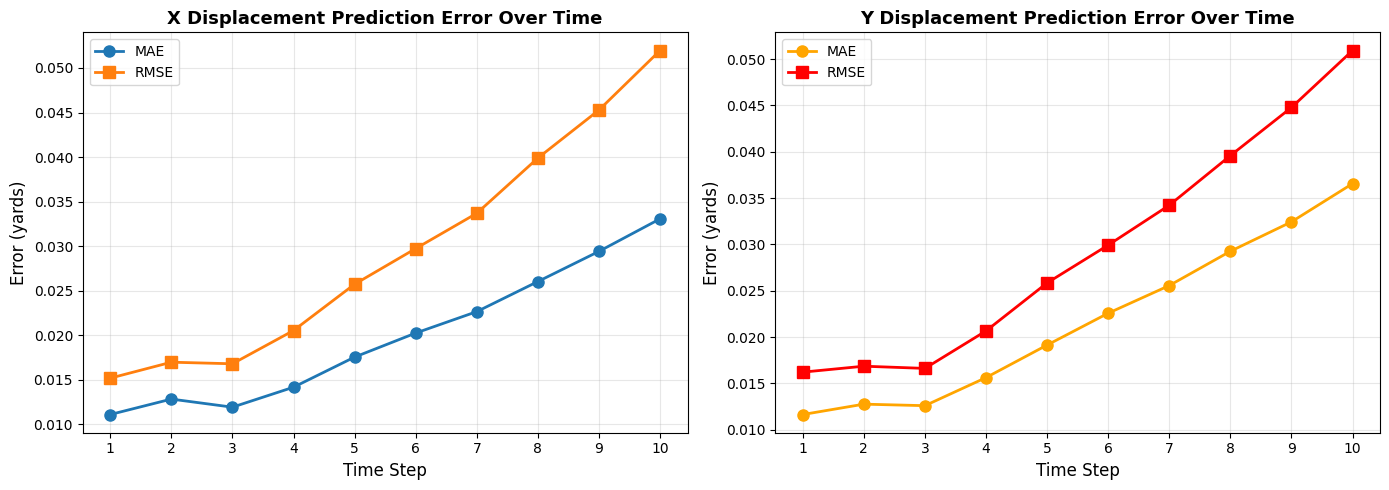

In [90]:
# Create summary tables
print("\n" + "="*70)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*70)

print("\n--- X DISPLACEMENT MODELS ---")
print(f"{'Model':<8} {'MAE':<12} {'RMSE':<12} {'MSE':<12} {'N_Samples':<10}")
print("-" * 70)
for t in range(1, MAX_HORIZON + 1):
    n_samples = len(master_data[master_data['num_output_frames'] >= t])
    print(f"t+{t:<6} {metrics_x[t][:,0].mean():.4f}±{metrics_x[t][:,0].std():.3f}  "
          f"{metrics_x[t][:,1].mean():.4f}±{metrics_x[t][:,1].std():.3f}  "
          f"{metrics_x[t][:,2].mean():.6f}±{metrics_x[t][:,2].std():.5f}  {n_samples:<10}")

print("\n--- Y DISPLACEMENT MODELS ---")
print(f"{'Model':<8} {'MAE':<12} {'RMSE':<12} {'MSE':<12} {'N_Samples':<10}")
print("-" * 70)
for t in range(1, MAX_HORIZON + 1):
    n_samples = len(master_data[master_data['num_output_frames'] >= t])
    print(f"t+{t:<6} {metrics_y[t][:,0].mean():.4f}±{metrics_y[t][:,0].std():.3f}  "
          f"{metrics_y[t][:,1].mean():.4f}±{metrics_y[t][:,1].std():.3f}  "
          f"{metrics_y[t][:,2].mean():.6f}±{metrics_y[t][:,2].std():.5f}  {n_samples:<10}")

# Plot performance trends
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# X displacement
time_steps = list(range(1, MAX_HORIZON + 1))
mae_x_means = [metrics_x[t][:,0].mean() for t in time_steps]
rmse_x_means = [metrics_x[t][:,1].mean() for t in time_steps]

axes[0].plot(time_steps, mae_x_means, 'o-', label='MAE', linewidth=2, markersize=8)
axes[0].plot(time_steps, rmse_x_means, 's-', label='RMSE', linewidth=2, markersize=8)
axes[0].set_xlabel('Time Step', fontsize=12)
axes[0].set_ylabel('Error (yards)', fontsize=12)
axes[0].set_title('X Displacement Prediction Error Over Time', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(time_steps)

# Y displacement
mae_y_means = [metrics_y[t][:,0].mean() for t in time_steps]
rmse_y_means = [metrics_y[t][:,1].mean() for t in time_steps]

axes[1].plot(time_steps, mae_y_means, 'o-', label='MAE', linewidth=2, markersize=8, color='orange')
axes[1].plot(time_steps, rmse_y_means, 's-', label='RMSE', linewidth=2, markersize=8, color='red')
axes[1].set_xlabel('Time Step', fontsize=12)
axes[1].set_ylabel('Error (yards)', fontsize=12)
axes[1].set_title('Y Displacement Prediction Error Over Time', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(time_steps)

plt.tight_layout()
plt.show()


### Trajectory Visualization: Predicted vs True Paths


In [91]:
# Sample 10 players from validation set with at least 10 output frames
# Use last fold from Model 10 for sampling

# Get validation indices from last fold of Model 10
data_for_model_10 = master_data[master_data['num_output_frames'] >= 10].copy()
X_m10 = data_for_model_10[base_features + [f"target_dx_t{t}" for t in range(1, 10)]].copy()
y_m10 = data_for_model_10["target_dx_t10"].copy()
groups_m10 = data_for_model_10["game_id"].copy()

if 'player_to_predict' in X_m10.columns:
    X_m10["player_to_predict"] = X_m10["player_to_predict"].astype(np.int8)
X_m10 = X_m10.astype(np.float32)
y_m10 = y_m10.astype(np.float32)
groups_m10 = groups_m10.astype(np.float32)

gkf = GroupKFold(n_splits=5)
_, va_idx_m10 = list(gkf.split(X_m10, y_m10, groups_m10))[-1]

# Get validation data
val_data_m10 = data_for_model_10.iloc[va_idx_m10].copy()

# Sample 10 random players
np.random.seed(42)
sample_players = val_data_m10[["game_id", "play_id", "nfl_id"]].drop_duplicates().sample(n=min(10, len(val_data_m10)))

print(f"\nSampled {len(sample_players)} players for trajectory visualization")
print(sample_players)



Sampled 10 players for trajectory visualization
          game_id  play_id  nfl_id
9445   2023120307     1671   46109
566    2023120306     2825   52474
169    2023121100     2456   46277
15425  2023120305     1243   52535
37916  2024010601     2997   35459
33687  2023112609      580   43351
5965   2023120308      169   44878
42479  2023102904     1417   46775
32474  2023120700     1637   54673
15809  2023112606     2046   55937


### Generate Sequential Predictions for Sample Players


In [95]:
# For each sampled player, generate sequential predictions using models 1-10
# Use last fold models (index -1)

trajectories = []

for idx, (gid, pid, nid) in sample_players.iterrows():
    print(f"\nPredicting trajectory for Player {len(trajectories)+1}: game={gid}, play={pid}, nfl_id={nid}")
    
    # Get player's base features
    player_data = master_data[
        (master_data["game_id"] == gid) & 
        (master_data["play_id"] == pid) & 
        (master_data["nfl_id"] == nid)
    ].copy()
    
    if player_data.empty:
        continue
    
    # Get t0 position
    x0 = player_data["x0"].values[0]
    y0 = player_data["y0"].values[0]
    
    # Prepare base features
    base_feats = player_data[base_features].copy()
    if 'player_to_predict' in base_feats.columns:
        base_feats["player_to_predict"] = base_feats["player_to_predict"].astype(np.int8)
    base_feats = base_feats.astype(np.float32)
    
    # Sequential prediction
    pred_x_displacements = []
    pred_y_displacements = []
    true_x_displacements = []
    true_y_displacements = []
    
    for t in range(1, MAX_HORIZON + 1):
        # Prepare features for X model
        if t == 1:
            X_pred_x = base_feats.copy()
        else:
            # Add previous X predictions as features
            X_pred_x = base_feats.copy()
            for prev_t in range(1, t):
                X_pred_x[f"target_dx_t{prev_t}"] = pred_x_displacements[prev_t - 1]
        
        # Prepare features for Y model
        if t == 1:
            X_pred_y = base_feats.copy()
        else:
            # Add previous Y predictions as features
            X_pred_y = base_feats.copy()
            for prev_t in range(1, t):
                X_pred_y[f"target_dy_t{prev_t}"] = pred_y_displacements[prev_t - 1]
        
        # Predict X and Y displacements using separate feature sets
        pred_dx = models_x[t][-1].predict(X_pred_x)[0]  # Use last fold model
        pred_dy = models_y[t][-1].predict(X_pred_y)[0]
        
        pred_x_displacements.append(pred_dx)
        pred_y_displacements.append(pred_dy)
        
        # Get true displacements
        true_dx = player_data[f"target_dx_t{t}"].values[0]
        true_dy = player_data[f"target_dy_t{t}"].values[0]
        
        true_x_displacements.append(true_dx)
        true_y_displacements.append(true_dy)
    
    # Convert displacements to positions
    pred_x_positions = [x0] + [x0 + pred_x_displacements[i] for i in range(MAX_HORIZON)]
    pred_y_positions = [y0] + [y0 + pred_y_displacements[i] for i in range(MAX_HORIZON)]
    
    true_x_positions = [x0] + [x0 + true_x_displacements[i] for i in range(MAX_HORIZON)]
    true_y_positions = [y0] + [y0 + true_y_displacements[i] for i in range(MAX_HORIZON)]
    
    trajectories.append({
        "game_id": gid,
        "play_id": pid,
        "nfl_id": nid,
        "x0": x0,
        "y0": y0,
        "pred_x": pred_x_positions,
        "pred_y": pred_y_positions,
        "true_x": true_x_positions,
        "true_y": true_y_positions
    })

print(f"\nGenerated {len(trajectories)} trajectories")



Predicting trajectory for Player 1: game=2023120307, play=1671, nfl_id=46109

Predicting trajectory for Player 2: game=2023120306, play=2825, nfl_id=52474

Predicting trajectory for Player 3: game=2023121100, play=2456, nfl_id=46277

Predicting trajectory for Player 4: game=2023120305, play=1243, nfl_id=52535

Predicting trajectory for Player 5: game=2024010601, play=2997, nfl_id=35459

Predicting trajectory for Player 6: game=2023112609, play=580, nfl_id=43351

Predicting trajectory for Player 7: game=2023120308, play=169, nfl_id=44878

Predicting trajectory for Player 8: game=2023102904, play=1417, nfl_id=46775

Predicting trajectory for Player 9: game=2023120700, play=1637, nfl_id=54673

Predicting trajectory for Player 10: game=2023112606, play=2046, nfl_id=55937

Generated 10 trajectories


### Plot Trajectories: Predicted vs True


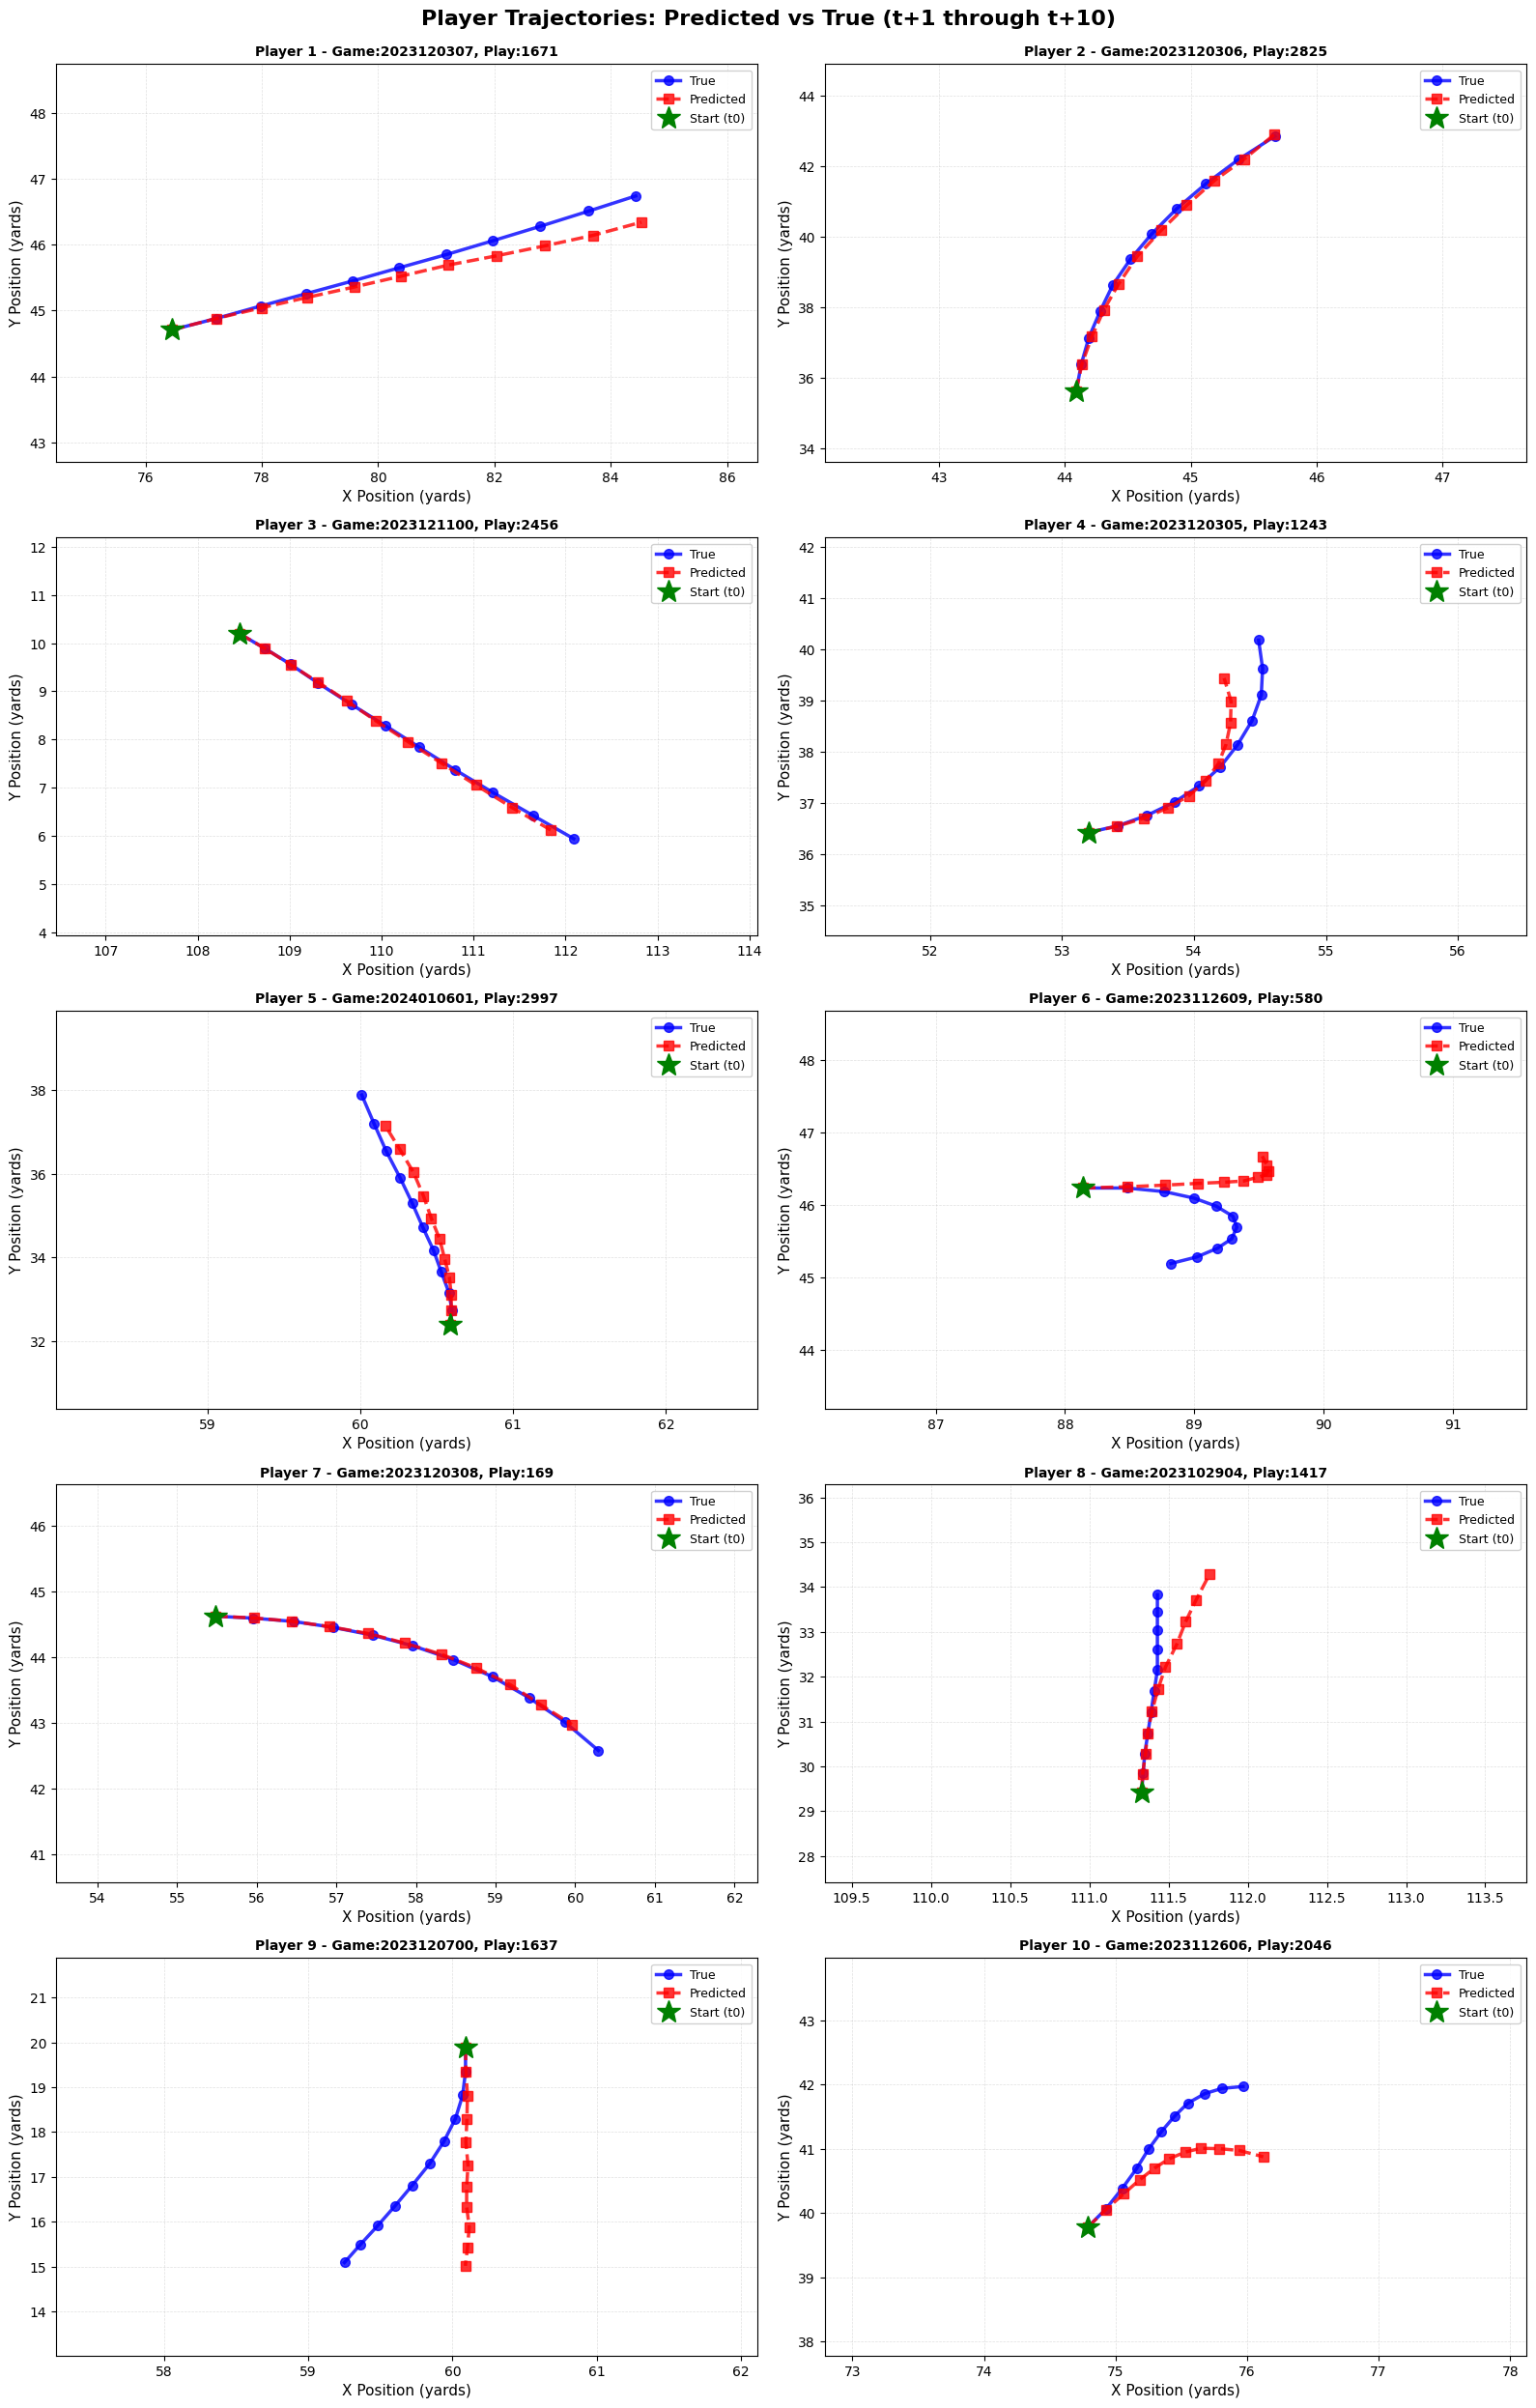


TRAJECTORY PREDICTION ERRORS
Player 1: Mean error = 0.182 yards, Final error (t+10) = 0.410 yards
Player 2: Mean error = 0.072 yards, Final error (t+10) = 0.045 yards
Player 3: Mean error = 0.147 yards, Final error (t+10) = 0.311 yards
Player 4: Mean error = 0.365 yards, Final error (t+10) = 0.785 yards
Player 5: Mean error = 0.349 yards, Final error (t+10) = 0.748 yards
Player 6: Mean error = 0.692 yards, Final error (t+10) = 1.639 yards
Player 7: Mean error = 0.188 yards, Final error (t+10) = 0.518 yards
Player 8: Mean error = 0.152 yards, Final error (t+10) = 0.564 yards
Player 9: Mean error = 0.364 yards, Final error (t+10) = 0.842 yards
Player 10: Mean error = 0.522 yards, Final error (t+10) = 1.105 yards


In [97]:
# Create a grid of subplots for all 10 trajectories
n_cols = 2
n_rows = (len(trajectories) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, traj in enumerate(trajectories):
    ax = axes[idx]
    
    # Plot true trajectory
    ax.plot(traj["true_x"], traj["true_y"], 'o-', 
            color='blue', linewidth=2.5, markersize=7, label='True', alpha=0.8)
    
    # Plot predicted trajectory
    ax.plot(traj["pred_x"], traj["pred_y"], 's--', 
            color='red', linewidth=2.5, markersize=7, label='Predicted', alpha=0.8)
    
    # Mark starting position
    ax.plot(traj["x0"], traj["y0"], '*', 
            color='green', markersize=18, label='Start (t0)', zorder=5)
    
    # Calculate dynamic axis limits based on the trajectories
    all_x = traj["true_x"] + traj["pred_x"]
    all_y = traj["true_y"] + traj["pred_y"]
    
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    
    # Add padding (20% of range or minimum 2 yards)
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_padding = max(x_range * 0.2, 2)
    y_padding = max(y_range * 0.2, 2)
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Labels and formatting
    ax.set_xlabel('X Position (yards)', fontsize=11)
    ax.set_ylabel('Y Position (yards)', fontsize=11)
    ax.set_title(f'Player {idx+1} - Game:{traj["game_id"]}, Play:{traj["play_id"]}', 
                 fontsize=10, fontweight='bold')
    ax.legend(fontsize=9, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.5)

# Hide extra subplots if any
for idx in range(len(trajectories), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Player Trajectories: Predicted vs True (t+1 through t+10)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Calculate average trajectory error
print("\n" + "="*70)
print("TRAJECTORY PREDICTION ERRORS")
print("="*70)

for idx, traj in enumerate(trajectories):
    errors = []
    for t in range(MAX_HORIZON):
        dx = traj["pred_x"][t+1] - traj["true_x"][t+1]
        dy = traj["pred_y"][t+1] - traj["true_y"][t+1]
        error = np.sqrt(dx**2 + dy**2)
        errors.append(error)
    
    mean_error = np.mean(errors)
    final_error = errors[-1]
    
    print(f"Player {idx+1}: Mean error = {mean_error:.3f} yards, Final error (t+10) = {final_error:.3f} yards")


## Save Models and Results


In [98]:
import pickle

# Create directory for sequential models
SEQUENTIAL_MODELS_DIR = f"{RESULTS_DIR}/sequential_models"
os.makedirs(SEQUENTIAL_MODELS_DIR, exist_ok=True)

print("="*70)
print("SAVING MODELS AND RESULTS")
print("="*70)

# Save all X models (10 models x 5 folds each)
print("\nSaving X displacement models...")
for model_num in range(1, MAX_HORIZON + 1):
    model_dir = f"{SEQUENTIAL_MODELS_DIR}/model_x_{model_num}"
    os.makedirs(model_dir, exist_ok=True)
    
    for fold_idx, model in enumerate(models_x[model_num]):
        model_path = f"{model_dir}/fold_{fold_idx}.pkl"
        joblib.dump(model, model_path)
    
    print(f"  Saved Model X {model_num}: {len(models_x[model_num])} folds")

# Save all Y models (10 models x 5 folds each)
print("\nSaving Y displacement models...")
for model_num in range(1, MAX_HORIZON + 1):
    model_dir = f"{SEQUENTIAL_MODELS_DIR}/model_y_{model_num}"
    os.makedirs(model_dir, exist_ok=True)
    
    for fold_idx, model in enumerate(models_y[model_num]):
        model_path = f"{model_dir}/fold_{fold_idx}.pkl"
        joblib.dump(model, model_path)
    
    print(f"  Saved Model Y {model_num}: {len(models_y[model_num])} folds")

# Save metrics
print("\nSaving metrics...")
metrics_to_save = {
    'metrics_x': {t: metrics_x[t] for t in range(1, MAX_HORIZON + 1)},
    'metrics_y': {t: metrics_y[t] for t in range(1, MAX_HORIZON + 1)},
    'max_horizon': MAX_HORIZON
}
with open(f"{SEQUENTIAL_MODELS_DIR}/metrics.pkl", 'wb') as f:
    pickle.dump(metrics_to_save, f)
print(f"  Saved metrics to metrics.pkl")

# Save base features list
print("\nSaving feature information...")
with open(f"{SEQUENTIAL_MODELS_DIR}/base_features.pkl", 'wb') as f:
    pickle.dump(base_features, f)
print(f"  Saved base_features list ({len(base_features)} features)")

# Save master data for future use (optional but useful)
print("\nSaving master dataset...")
master_data.to_parquet(f"{SEQUENTIAL_MODELS_DIR}/master_data.parquet", index=False)
print(f"  Saved master_data.parquet ({master_data.shape[0]} rows, {master_data.shape[1]} cols)")

# Save a summary JSON
print("\nSaving summary information...")
summary = {
    "max_horizon": MAX_HORIZON,
    "n_folds": 5,
    "n_models_x": len(models_x),
    "n_models_y": len(models_y),
    "n_base_features": len(base_features),
    "lgb_params": lgb_params,
    "total_samples": len(master_data),
    "samples_per_horizon": {
        t: int((master_data['num_output_frames'] >= t).sum()) 
        for t in range(1, MAX_HORIZON + 1)
    },
    "model_performance_x": {
        f"t+{t}": {
            "MAE_mean": float(metrics_x[t][:,0].mean()),
            "MAE_std": float(metrics_x[t][:,0].std()),
            "RMSE_mean": float(metrics_x[t][:,1].mean()),
            "RMSE_std": float(metrics_x[t][:,1].std()),
            "MSE_mean": float(metrics_x[t][:,2].mean()),
            "MSE_std": float(metrics_x[t][:,2].std()),
        }
        for t in range(1, MAX_HORIZON + 1)
    },
    "model_performance_y": {
        f"t+{t}": {
            "MAE_mean": float(metrics_y[t][:,0].mean()),
            "MAE_std": float(metrics_y[t][:,0].std()),
            "RMSE_mean": float(metrics_y[t][:,1].mean()),
            "RMSE_std": float(metrics_y[t][:,1].std()),
            "MSE_mean": float(metrics_y[t][:,2].mean()),
            "MSE_std": float(metrics_y[t][:,2].std()),
        }
        for t in range(1, MAX_HORIZON + 1)
    }
}

with open(f"{SEQUENTIAL_MODELS_DIR}/summary.json", 'w') as f:
    json.dump(summary, f, indent=2)
print(f"  Saved summary.json")

print("\n" + "="*70)
print("ALL MODELS AND RESULTS SAVED SUCCESSFULLY!")
print(f"Location: {SEQUENTIAL_MODELS_DIR}")
print("="*70)


SAVING MODELS AND RESULTS

Saving X displacement models...
  Saved Model X 1: 5 folds
  Saved Model X 2: 5 folds
  Saved Model X 3: 5 folds
  Saved Model X 4: 5 folds
  Saved Model X 5: 5 folds
  Saved Model X 6: 5 folds
  Saved Model X 7: 5 folds
  Saved Model X 8: 5 folds
  Saved Model X 9: 5 folds
  Saved Model X 10: 5 folds

Saving Y displacement models...
  Saved Model Y 1: 5 folds
  Saved Model Y 2: 5 folds
  Saved Model Y 3: 5 folds
  Saved Model Y 4: 5 folds
  Saved Model Y 5: 5 folds
  Saved Model Y 6: 5 folds
  Saved Model Y 7: 5 folds
  Saved Model Y 8: 5 folds
  Saved Model Y 9: 5 folds
  Saved Model Y 10: 5 folds

Saving metrics...
  Saved metrics to metrics.pkl

Saving feature information...
  Saved base_features list (49 features)

Saving master dataset...
  Saved master_data.parquet (45250 rows, 81 cols)

Saving summary information...
  Saved summary.json

ALL MODELS AND RESULTS SAVED SUCCESSFULLY!
Location: results/sequential_models


In [ ]:
# CODE TO LOAD MODELS (Run this cell instead of training if models already exist)
# Uncomment and run when you want to reload saved models

"""
import pickle
import joblib

SEQUENTIAL_MODELS_DIR = f"{RESULTS_DIR}/sequential_models"

print("="*70)
print("LOADING SAVED MODELS AND RESULTS")
print("="*70)

# Load summary
with open(f"{SEQUENTIAL_MODELS_DIR}/summary.json", 'r') as f:
    summary = json.load(f)
    MAX_HORIZON = summary['max_horizon']
    print(f"\nMax horizon: {MAX_HORIZON}")

# Load base features
with open(f"{SEQUENTIAL_MODELS_DIR}/base_features.pkl", 'rb') as f:
    base_features = pickle.load(f)
    print(f"Base features: {len(base_features)}")

# Load metrics
with open(f"{SEQUENTIAL_MODELS_DIR}/metrics.pkl", 'rb') as f:
    metrics_data = pickle.load(f)
    metrics_x = metrics_data['metrics_x']
    metrics_y = metrics_data['metrics_y']
    print(f"Loaded metrics for {len(metrics_x)} X models and {len(metrics_y)} Y models")

# Load master data
master_data = pd.read_parquet(f"{SEQUENTIAL_MODELS_DIR}/master_data.parquet")
print(f"Loaded master_data: {master_data.shape}")

# Load all X models
print("\nLoading X displacement models...")
models_x = {}
for model_num in range(1, MAX_HORIZON + 1):
    model_dir = f"{SEQUENTIAL_MODELS_DIR}/model_x_{model_num}"
    models_x[model_num] = []
    
    for fold_idx in range(5):  # 5 folds
        model_path = f"{model_dir}/fold_{fold_idx}.pkl"
        model = joblib.load(model_path)
        models_x[model_num].append(model)
    
    print(f"  Loaded Model X {model_num}: {len(models_x[model_num])} folds")

# Load all Y models
print("\nLoading Y displacement models...")
models_y = {}
for model_num in range(1, MAX_HORIZON + 1):
    model_dir = f"{SEQUENTIAL_MODELS_DIR}/model_y_{model_num}"
    models_y[model_num] = []
    
    for fold_idx in range(5):  # 5 folds
        model_path = f"{model_dir}/fold_{fold_idx}.pkl"
        model = joblib.load(model_path)
        models_y[model_num].append(model)
    
    print(f"  Loaded Model Y {model_num}: {len(models_y[model_num])} folds")

print("\n" + "="*70)
print("ALL MODELS AND RESULTS LOADED SUCCESSFULLY!")
print("="*70)

# Now you can use models_x, models_y, metrics_x, metrics_y, etc.
"""

print("To load saved models, uncomment and run the code above.")
